In [1]:
import glob
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import xarray as xr

plt.style.use("ggplot")

# ICP Waters GP review 2022

The notebook compiles data for the 2022 GP Review for the WGE. I don't actually know what these acronyms mean (!), but the data required are described by Øyvind G in e-mails received 24.03.2022 at 11.18 and 18.17.

## 1. Get data from RESA2

**Note:** Code in this section requires a direct connection to Nivabasen.

In [ ]:
eng = nivapy.da.connect()

In [ ]:
st_dt = "2000-01-01"
end_dt = "2019-12-31"
par_list = ["Ca", "Mg", "Na", "K", "SO4", "NO3-N", "NH4-N", "Cl"]

### 1.1. Get stations

The previous analysis in 2015 considered 61 stations. Some of these have been replaced in ICPW and others removed from the dataset completely (see e-mail sent to Heleen and Øyvind on 09.05.2022 at 15:41 for details). For the current review, we will use 59 sites (see reply from Heleen received 09.05.2022 at 16.09).

In [ ]:
oga_df = pd.read_excel("stations_used_2015.xlsx")
oga_df.dropna(subset="Tr18_Code", inplace=True)
stn_cds = list(oga_df["Tr18_Code"].unique())

stn_df = nivapy.da.select_resa_stations(eng)
stn_df = stn_df.query("station_code in @stn_cds")
assert len(oga_df) == len(stn_df), "Not all stations identified in RESA."
stn_df = pd.merge(
    stn_df,
    oga_df[["Tr18_Code", "Region", "Country"]],
    how="left",
    left_on="station_code",
    right_on="Tr18_Code",
)
del stn_df["Tr18_Code"]
stn_df.columns = [col.lower() for col in stn_df.columns]
stn_df.to_csv("stations_used_2022.csv", index=False)
stn_df.head()

In [ ]:
nivapy.spatial.quickmap(stn_df, popup="station_name", cluster=True, kartverket=True)

### 1.2. Get parameters

In [ ]:
par_df = nivapy.da.select_resa_station_parameters(stn_df, st_dt, end_dt, eng)
par_df = par_df.query("parameter_name in @par_list")
assert len(par_df) == len(par_list), "Not all parameters available."
par_df

### 1.3. Get water chemistry

In [ ]:
def convert_to_microequivalents(df, sea_salt_corr=False):
    """Basic conversion from mass/l to microequivalents/l.

    Arguments:
        df {DataFrame} -- Raw water chemistry from Nivabasen
        sea_salt_corr {bool} -- Whether to also apply sea-salt correction

    Raises:
        ValueError: If the appropriate unit factor cannot be identified.
        Assertion error if sea_salt_corr is True and 'Cl_mg/l' is not in 'df'

    Returns:
        DataFrame -- 'df' is returned with additional columns added.
    """
    if sea_salt_corr:
        assert (
            "Cl_mg/l" in df.columns
        ), "Column 'Cl_mg/l' is required if 'sea_salt_corr' is True."

    chem_prop_df = pd.read_csv(r"chemical_properties.csv", sep=";")

    for idx, row in chem_prop_df.iterrows():
        par_unit = row["par"]
        valency = row["valency"]
        molar_mass = row["molar_mass"]
        cl_ratio = row["cl_ratio"]

        if par_unit in df.columns:
            par, unit = par_unit.split("_")

            if unit[0] == "m":
                factor = 1000
            elif unit[0] == "µ":
                factor = 1
            else:
                raise ValueError("Unit factor could not be identified.")

            df[f"{par}_µekv/l"] = df[par_unit] * valency * factor / molar_mass

            if sea_salt_corr and cl_ratio:
                df[f"{par}*_µekv/l"] = df[f"{par}_µekv/l"] - (
                    cl_ratio * df["Cl_µekv/l"]
                )

    # Remove unwanted columns
    for col in ["Cl*_µekv/l", "NO3-N*_µekv/l", "NH4-N*_µekv/l"]:
        if col in df.columns:
            del df[col]

    return df


def calculate_anc(df):
    """Calculate ANC.
    Arguments:
        df {DataFrame} -- Water chemsitry data.
    Returns:
        DataFrame -- New column added to 'df'.
    """
    req_pars = [
        "Ca_µekv/l",
        "Mg_µekv/l",
        "Na_µekv/l",
        "K_µekv/l",
        "NH4-N_µekv/l",
        "Cl_µekv/l",
        "SO4_µekv/l",
        "NO3-N_µekv/l",
    ]
    df_pars = list(df.columns)
    if all(par in df_pars for par in req_pars):
        # Assume NH4 is zero if not measured
        df["NH4-N_µekv/l"].fillna(value=0, inplace=True)

        df["ANC_µekv/l"] = (
            df["Ca_µekv/l"]
            + df["Mg_µekv/l"]
            + df["Na_µekv/l"]
            + df["K_µekv/l"]
            + df["NH4-N_µekv/l"]
            - df["Cl_µekv/l"]
            - df["SO4_µekv/l"]
            - df["NO3-N_µekv/l"]
        )

    return df

In [ ]:
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(
    stn_df, par_df, st_dt, end_dt, eng, lod_flags=False, drop_dups=True
)
wc_df.rename(
    {"NO3-N_µg/l N": "NO3-N_µg/l", "NH4-N_µg/l N": "NH4-N_µg/l"},
    axis="columns",
    inplace=True,
)
wc_df = convert_to_microequivalents(wc_df, sea_salt_corr=True)
wc_df = calculate_anc(wc_df)
wc_df = wc_df.query("(depth1 == 0) and (depth2 == 0)")
wc_df["year"] = wc_df["sample_date"].dt.year
wc_df = (
    wc_df.groupby(["station_id", "station_code", "station_name", "year"])
    .mean()
    .reset_index()
)

# Remove unwanted units
for col in wc_df.columns:
    if col.split("_")[-1] in ("mg/l", "µg/l"):
        del wc_df[col]

wc_df.to_csv("water_chem.csv", index=False)

wc_df.head()

## 2. Get deposition

Code from here onwards should be run on JupyterHub.

In [2]:
# Read data from Nivabasen
stn_df = pd.read_csv("stations_used_2022.csv")
wc_df = pd.read_csv("water_chem.csv")

### 2.1. "Standard" EMEP data from 2000 to 2019

Available from [here](https://www.emep.int/mscw/mscw_moddata.html) (`2000-2018 (Type2) and 2019 (Type1)`).

In [3]:
# List files to process
file_paths = [
    f"https://thredds.met.no/thredds/dodsC/data/EMEP/2021_Reporting/EMEP01_rv4.42_year.{year}met_{year}emis_rep2021.nc"
    for year in range(2000, 2019)
]

# Data for 2019 have a different naming convention/url
file_paths += [
    r"https://thredds.met.no/thredds/dodsC/data/EMEP/2021_Reporting/EMEP01_rv4.42_year.2019met_2019emis.nc"
]

In [4]:
# Open datasets
ds = xr.open_mfdataset(
    file_paths,
    combine="by_coords",
)
ds

<xarray.Dataset>
Dimensions:             (lon: 1200, lat: 520, time: 20)
Coordinates:
  * lon                 (lon) float64 -29.95 -29.85 -29.75 ... 89.75 89.85 89.95
  * lat                 (lat) float64 30.05 30.15 30.25 ... 81.75 81.85 81.95
  * time                (time) datetime64[ns] 2000-07-02 ... 2019-07-02T12:00:00
Data variables: (12/49)
    SURF_ugN_NOX        (time, lat, lon) float64 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ugN_RDN        (time, lat, lon) float64 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ugN_OXN        (time, lat, lon) float64 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_PREC           (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_SOX            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_OXN            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    ...                  ...
    SURF_ug_ECFINE      (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_ECCOARSE    (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM25        (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM_coarse   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM25_rh50   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM10_rh50   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
Attributes:
    vert_coord:                      atmosphere_hybrid_sigma_pressure_coordinate
    Conventions:                     CF-1.6 for coordinates
    model:                           EMEP_MSC-W
    author_of_run:                   emepctm group
    created_date:                    20210814
    created_hour:                    000608.038
    projection:                      lon lat
    period_type:                     fullrun
    run_label:                       rv4_42
    lastmodified_date:               20210816
    lastmodified_hour:               000013.715
    DODS_EXTRA.Unlimited_Dimension:  time

In [5]:
# Load data from URL into memory to improve performance later
ds = ds.load()

In [6]:
def calculate_dep_totals(ds):
    """Takes an xarray netCDF dataset in the format used by EMEP and calculates
    grid average deposition totals:

        Total SOx = Wet SOx + Dry SOx
        Total OxN = Wet OxN + Dry OxN
        Total RedN = Wet RedN + Dry RedN
        Total N = Total OxN + Total RedN

    Args:
        ds: xarray dataset

    Returns:
        New variables are added to 'ds'.
    """
    # Pars of interest
    par_list = [
        "DDEP_SOX_m2Grid",
        "WDEP_SOX",
        "DDEP_OXN_m2Grid",
        "WDEP_OXN",
        "DDEP_RDN_m2Grid",
        "WDEP_RDN",
    ]

    # Check N units are consistent
    for par in par_list:
        unit = ds[par].attrs["units"]
        assert unit in ["mgS/m2", "mgN/m2"], "Units not consistent."

    # Calculate total oxidised S
    ds["DEP_SOX"] = ds["WDEP_SOX"] + ds["DDEP_SOX_m2Grid"]
    ds["DEP_SOX"].attrs["units"] = "mgS/m2"

    # Calculate total oxidised N
    ds["DEP_OXN"] = ds["WDEP_OXN"] + ds["DDEP_OXN_m2Grid"]
    ds["DEP_OXN"].attrs["units"] = "mgN/m2"

    # Calculate total reduced N
    ds["DEP_RDN"] = ds["WDEP_RDN"] + ds["DDEP_RDN_m2Grid"]
    ds["DEP_RDN"].attrs["units"] = "mgN/m2"

    # Calculate total N
    ds["DEP_TOTN"] = (
        ds["WDEP_OXN"] + ds["WDEP_RDN"] + ds["DDEP_OXN_m2Grid"] + ds["DDEP_RDN_m2Grid"]
    )
    ds["DEP_TOTN"].attrs["units"] = "mgN/m2"

    return ds

In [7]:
# Sum vars in EMEP netCDFs
ds = calculate_dep_totals(ds)

# Get time series for points
par_list = ["DEP_SOX", "DEP_TOTN"]
stn_ds = stn_df.set_index("station_id").to_xarray()
emep_df = (
    ds[par_list]
    .sel(lat=stn_ds["latitude"], lon=stn_ds["longitude"], method="nearest")
    .to_dataframe()
    .reset_index()
)

emep_df["year"] = emep_df["time"].dt.year
emep_df = emep_df[["station_id", "year"] + par_list]
par_unit = [f"EMEP_Standard_{i}_mgpm2" for i in par_list]
emep_df.columns = ["station_id", "year"] + par_unit
emep_df.to_csv("emep_standard_dep.csv", index=False)
emep_df.head()

,station_id,year,EMEP_Standard_DEP_SOX_mgpm2,EMEP_Standard_DEP_TOTN_mgpm2
0,23505,2000,771.877930,1980.211548
1,23506,2000,801.317627,2200.603271
2,23507,2000,955.123718,2178.717773
3,23509,2000,690.235046,1696.147583
4,23510,2000,751.697388,2001.476685


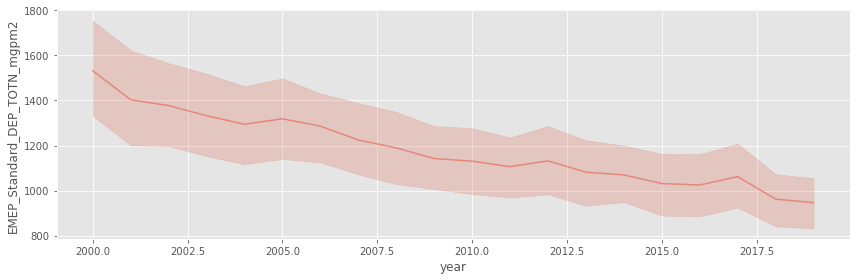

In [8]:
sn.relplot(
    data=emep_df,
    x="year",
    y="EMEP_Standard_DEP_TOTN_mgpm2",
    height=4,
    aspect=3,
    kind="line",
    legend=False,
    alpha=0.5,
)

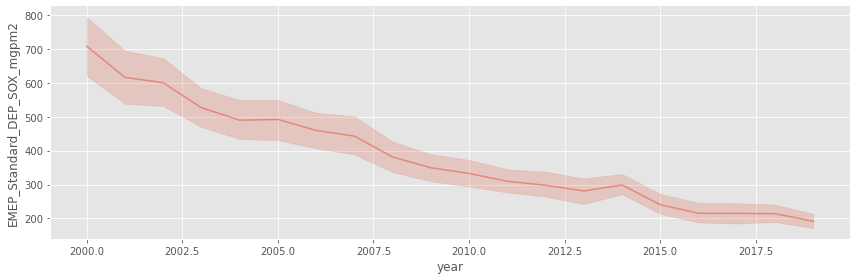

In [9]:
sn.relplot(
    data=emep_df,
    x="year",
    y="EMEP_Standard_DEP_SOX_mgpm2",
    height=4,
    aspect=3,
    kind="line",
    legend=False,
    alpha=0.5,
)

### 2.2. EMEP Scenarios

Prepared for the GP review and downloaded from [here](https://aerocom-classic.met.no/DATA/download/GP_review_WGE/) (see e-mail from Heleen received 05.05.2022 at 12:25 for details).

In [10]:
search_path = r"/home/jovyan/shared/icp_waters/deposition_data/gp_review_scenarios/*.nc"
flist = glob.glob(search_path)

par_list = ["DEP_SOX", "DEP_TOTN"]
stn_ds = stn_df.set_index("station_id").to_xarray()

df_list = []
for fpath in flist:
    met, emis, scen = os.path.split(fpath)[1].split("_")[2:5]

    ds = xr.open_dataset(fpath)
    ds = calculate_dep_totals(ds)
    scen_df = (
        ds[par_list]
        .sel(lat=stn_ds["latitude"], lon=stn_ds["longitude"], method="nearest")
        .to_dataframe()
        .reset_index()
    )
    # scen_df["year"] = scen_df["time"].dt.year
    scen_df["year"] = int(emis[-4:])
    scen_df = scen_df[["station_id", "year"] + par_list]
    par_names = [f"{met}_{emis}_{scen}_{i}_mgpm2" for i in par_list]
    scen_df.columns = ["station_id", "year"] + par_names
    df_list.append(scen_df.set_index(["station_id", "year"]))

scen_df = pd.concat(df_list, axis="columns").reset_index()
scen_df.to_csv("emep_scenario_dep.csv", index=False)
scen_df.head()

,station_id,year,met2005_emis2050_MFR_DEP_SOX_mgpm2,met2005_emis2050_MFR_DEP_TOTN_mgpm2,met2015_emis2015_Baseline_DEP_SOX_mgpm2,met2015_emis2015_Baseline_DEP_TOTN_mgpm2,met2015_emis2050_Diet_DEP_SOX_mgpm2,met2015_emis2050_Diet_DEP_TOTN_mgpm2,met2015_emis2050_MFR_DEP_SOX_mgpm2,met2015_emis2050_MFR_DEP_TOTN_mgpm2,...,met2005_emis2030_MFR_DEP_SOX_mgpm2,met2005_emis2030_MFR_DEP_TOTN_mgpm2,met2015_emis2030_MFR_DEP_SOX_mgpm2,met2015_emis2030_MFR_DEP_TOTN_mgpm2,met2005_emis2050_Baseline_DEP_SOX_mgpm2,met2005_emis2050_Baseline_DEP_TOTN_mgpm2,met2015_emis2030_Baseline_DEP_SOX_mgpm2,met2015_emis2030_Baseline_DEP_TOTN_mgpm2,met2015_emis2050_Baseline_DEP_SOX_mgpm2,met2015_emis2050_Baseline_DEP_TOTN_mgpm2
0,23505,2050,124.942520,685.732178,NaN,NaN,81.991058,399.547852,80.562759,560.359741,...,NaN,NaN,NaN,NaN,160.899185,938.511414,NaN,NaN,105.285553,774.846558
1,23506,2050,97.851166,648.486267,NaN,NaN,74.112953,416.123291,73.463486,603.493713,...,NaN,NaN,NaN,NaN,135.919281,935.084229,NaN,NaN,104.516380,876.620850
2,23507,2050,132.457336,650.984314,NaN,NaN,107.765915,422.053375,108.423981,585.214844,...,NaN,NaN,NaN,NaN,188.047974,886.937439,NaN,NaN,157.513794,795.552429
3,23509,2050,105.554344,561.825195,NaN,NaN,77.974495,386.875977,73.708893,546.989197,...,NaN,NaN,NaN,NaN,123.000252,760.366577,NaN,NaN,90.151138,748.880798
4,23510,2050,95.126831,567.324585,NaN,NaN,72.078804,370.725281,71.670013,518.761841,...,NaN,NaN,NaN,NaN,129.600784,780.325439,NaN,NaN,102.440598,715.870239


## 3. Get runoff

## 4. Merge all data

In [11]:
stn_df = pd.read_csv("stations_used_2022.csv")
wc_df = pd.read_csv("water_chem.csv").set_index(["station_id", "year"])
del wc_df["station_code"], wc_df["station_name"]
emep_df = pd.read_csv("emep_standard_dep.csv").set_index(["station_id", "year"])
scen_df = pd.read_csv("emep_scenario_dep.csv").set_index(["station_id", "year"])
df_list = [wc_df, emep_df, scen_df]
df = pd.concat(df_list, axis="columns").reset_index()
df.sort_values(["station_id", "year"], inplace=True)
df = pd.merge(df, stn_df, on="station_id", how="left")

# Tidy cols for clarity
first = [
    "station_id",
    "station_code",
    "station_name",
    "region",
    "country",
    "latitude",
    "longitude",
    "altitude",
    "depth1",
    "depth2",
    "year",
]
second = [col for col in df.columns if (not col.startswith("met") and col not in first)]
third = sorted([col for col in df.columns if col.startswith("met")])
df = df[first + second + third]
del df["depth1"], df["depth2"]
for col in df.columns:
    if col not in first:
        df[col] = df[col].round(1)

df.to_csv("icpw_gp_review_data_combined.csv", index=False)
df.head()

,station_id,station_code,station_name,latitude,longitude,altitude,year,Cl_µekv/l,Ca_µekv/l,Ca*_µekv/l,...,met2015_emis2030_Baseline_DEP_SOX_mgpm2,met2015_emis2030_Baseline_DEP_TOTN_mgpm2,met2015_emis2030_MFR_DEP_SOX_mgpm2,met2015_emis2030_MFR_DEP_TOTN_mgpm2,met2015_emis2050_Baseline_DEP_SOX_mgpm2,met2015_emis2050_Baseline_DEP_TOTN_mgpm2,met2015_emis2050_Diet_DEP_SOX_mgpm2,met2015_emis2050_Diet_DEP_TOTN_mgpm2,met2015_emis2050_MFR_DEP_SOX_mgpm2,met2015_emis2050_MFR_DEP_TOTN_mgpm2
0,23505,DE01,"Schwarzwald, Dürreychbach",48.750167,8.4503,730.0,2000,53.592080,117.847121,115.515244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23505,DE01,"Schwarzwald, Dürreychbach",48.750167,8.4503,730.0,2001,81.563384,119.350600,116.332754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23505,DE01,"Schwarzwald, Dürreychbach",48.750167,8.4503,730.0,2002,66.049888,123.925013,121.481167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23505,DE01,"Schwarzwald, Dürreychbach",48.750167,8.4503,730.0,2003,71.456106,104.379793,101.735917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23505,DE01,"Schwarzwald, Dürreychbach",48.750167,8.4503,730.0,2004,75.289278,138.959798,136.174094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
